In [2]:
from IPython.display import HTML

HTML("""
<style>
div.text_cell_render {
    font-size: 11px !important;
    line-height: 1.2;
}

div.input_area pre {
    font-size: 7px !important;
}
div.highlight pre {
    font-size: 7px !important;
}

div.output_area pre,
div.output pre,
pre {
    font-size: 6px !important;
    line-height: 1 !important;
    white-space: pre-wrap !important;  /* optional: wraps long lines */
}
.jp-CodeCell .jp-InputPrompt,
div.prompt.input_prompt {
    font-size: 6px !important;
    padding-right: 2px !important;
    color: #888 !important;
}

.jp-OutputPrompt,
div.prompt.output_prompt {
    font-size: 6px !important;
    padding-right: 2px !important;
    color: #888 !important;
}
</style>
""")

## Problem Statement ##
Construct a linear regression that predicts a person's sleep duration based on their sleep quality, physical activity levels and stress levels. 

## Variables and Parameters ##
|         Description         |   Symbol   |    Dimension    |         Type         |
|:---------------------------:|:----------:|:---------------:|:--------------------:|
|        Sleep Duration       |    $Y$    |        $h$        | Dependent Variable |
|        Sleep Quality        |   $X_1$    |        1        | Independent Variable |
|Duration of Physical Activity|   $X_2$    | $\text{min}$   | Independent Variable |
|        Stress Level         |   $X_3$    |        1        | Independent Variable |
|Regression coefficient for intercept| $\beta _0$ |        $h$        |   Model Parameter    |
|Regression coefficient for sleep quality| $\beta _1$ |       $h$       |   Model Parameter    |
|Regression coefficient for physical activity duration| $\beta _2$ | $\frac{h}{min}$ |   Model Parameter    |
|Regression coefficient for stress level| $\beta _3$ |       $h$       |   Model Parameter    |
|         Error               | $\epsilon$ |      $h$         |   Variable |

## Assumptions & Constraints ##
- Linear regression assumptions are satisfied
- Participants could accurately gauge their own sleep quality & stress levels
- Participants reported their sleep quality, stress levels & physical activity levels accurately
- These are the only factors that influence sleep quality

## Build the Solution ##

Our model takes the form $\ln (Y) = \beta_0+ \beta_1 \ln (X_1)+\beta_2 X_2+\beta_3X_3+\epsilon$

In [5]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [7]:
## define the inputs and outputs for the regression
sleep_df = pd.read_csv("Sleep.csv")
X = sleep_df[["Quality", "Physical_Activity", "Stress"]]
Y = sleep_df["Duration"]

In [9]:
## make the necessary transformations
Y_log = np.log(Y)
Quality_log = np.zeros(len(sleep_df["Quality"]))
for i in range(len(sleep_df["Quality"])):
    Quality_log[i] = np.log(sleep_df["Quality"][i])
sleep_df["Quality Log"] = Quality_log
X_transformed = sleep_df[["Quality Log", "Physical_Activity", "Stress"]]

In [10]:
# run the regression
X_logged = sm.add_constant(X_transformed)
reg_logged = sm.OLS(Y_log, X_logged).fit()
summary_table_logged = reg_logged.summary()
print(summary_table_logged)

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     420.3
Date:                Thu, 27 Nov 2025   Prob (F-statistic):          8.92e-119
Time:                        17:41:47   Log-Likelihood:                 565.18
No. Observations:                 374   AIC:                            -1122.
Df Residuals:                     370   BIC:                            -1107.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2445      0.08

The model takes the form   
$\ln(\hat{Y}) = 1.2445 + 0.3963\cdot \ln(X_1) + 0.0004\cdot X_2 - 0.0177\cdot X_3$   
(which can also be written as $\hat{Y} = e^{1.2445}\cdot X_1^{0.3963}\cdot e^{0.0004 X_2}\cdot e^{-0.0177X_3}$). 

## Analyze & Assess ##

We selected this combination of transformations because we found it to violate the fewest linear regression assumptions, and because it appears to better fit the data overall.    

We found that the transformed model in fact has a lower adjusted R-squared value than the non-transformed version - but since the original model strongly violates many of the assumptions on the error, the higher adjusted R-squared means little. 

In [24]:
X = sm.add_constant(X)
reg_original = sm.OLS(Y,X).fit()

|         Model         |   R-squared   |    Adjusted R-squared    |
|:---------------------:|:-------------:|:------------------------:|
|    Non-transformed    |     0.785     |           0.783          |
|      Transformed      |     0.773     |           0.771          |

#### Assumption: Average Value of the Error is Zero ####

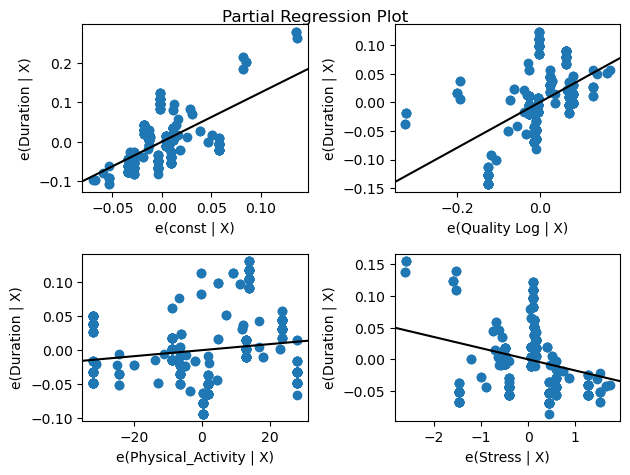

In [16]:
sm.graphics.plot_partregress_grid(reg_logged)
plt.show()

- The residual-covariate plots were good here, showing a random scatter around the line y=0. The residual-covariate plots for the non-transformed model also appeared random. 
- The partial regression plots, however, are scattered and the points lie only very approximately along the line - this means that the average value of the error is likely not zero, either in the transformed model (plots shown) or the original model (plots not shown)

#### Assumption: Variance of the Error is Constant ####

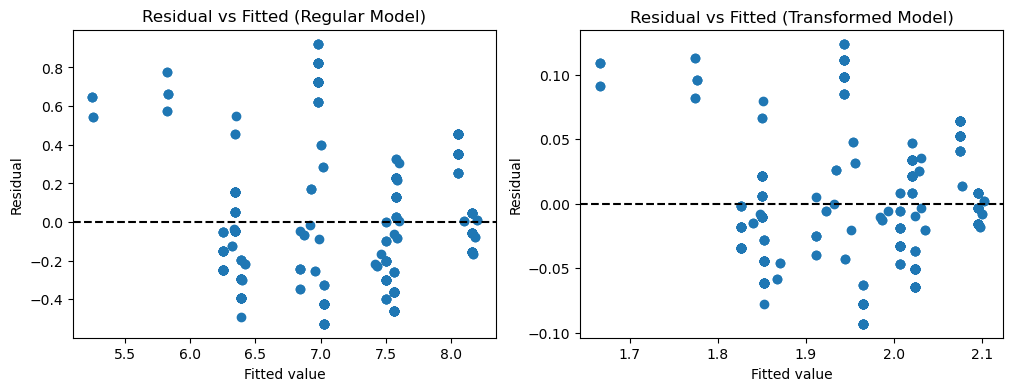

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fitted_y = reg_original.fittedvalues
residuals = reg_original.resid
fitted_y_log = reg_logged.fittedvalues
residuals_log = reg_logged.resid
axes[0].scatter(fitted_y, residuals)
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xlabel('Fitted value')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs Fitted (Regular Model)')

axes[1].scatter(fitted_y_log,residuals_log)
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xlabel('Fitted value')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual vs Fitted (Transformed Model)')
plt.show()

- The transformed model satisfies this assumption noticeably better than the original model, which has more points under the line y=0.
- The lack of a perfect random scatter here can also partially be attributed to the integer values taken by the 'sleep quality' and 'stress level' variables

#### Assumption: Error is a random sample from a normal distribution ####

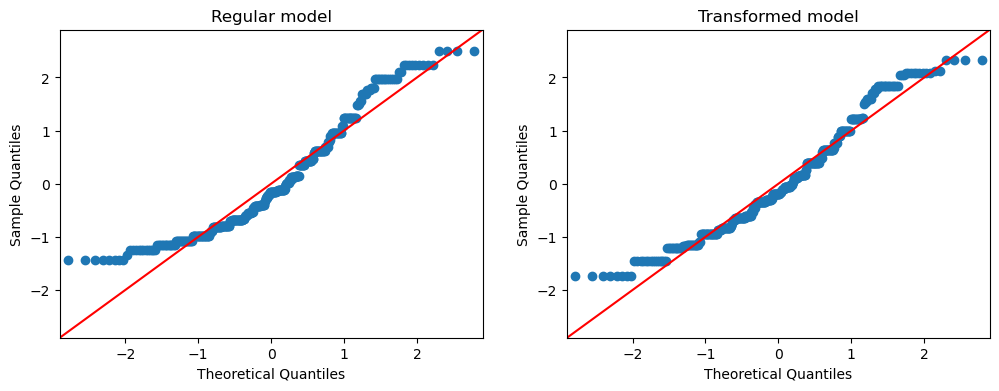

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.qqplot(residuals, fit=True, line="45", ax=axes[0])
axes[0].set_title('Regular model')

sm.qqplot(residuals_log, fit=True, line="45", ax=axes[1])
axes[1].set_title('Transformed model')
plt.show()

- While neither Q-Q plot is perfect, the one for the transformed model follows the line $y=x$ more closely - between -1 and 1 it is quite good, although it deviates more significantly outside this range
- The rough S-shape of the non-transformed Q-Q plot suggests that the distribution of $\vec{\epsilon}$ is more light-tailed than a standard normal distribution - this is improved but not eradicated by the transformations

#### Limitations of our Model ####

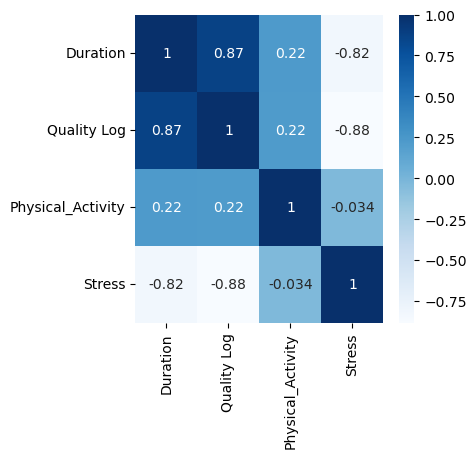

In [28]:
cor = pd.concat((Y_log, X_transformed), axis=1).corr()
plt.figure(figsize=(4, 4))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [29]:
X_transformed.describe().loc[['min', '25%', '50%', '75%', 'max']]

,Quality Log,Physical_Activity,Stress
min,1.386294,30.0,3.0
25%,1.791759,45.0,4.0
50%,1.945910,60.0,5.0
75%,2.079442,75.0,7.0
max,2.197225,90.0,8.0
